In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
hour_data=pd.read_csv('hour.csv')
hour_data[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


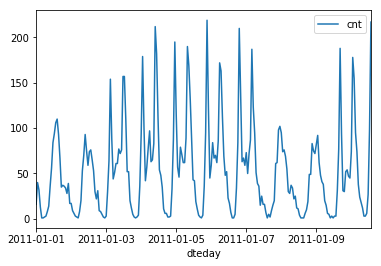

In [0]:
hour_data[:240].plot(x='dteday',y='cnt')

In [0]:
for_dummies=['season','mnth','hr','weekday','weathersit']
for i in for_dummies:
  dummy=pd.get_dummies(hour_data[i],prefix=i,drop_first=False)
  hour_data=pd.concat([hour_data,dummy],axis=1)
  
drop_fields=['season','mnth','hr','weekday','weathersit','instant','dteday','atemp']
data=hour_data.drop(drop_fields,axis=1)

In [0]:
quant_features=['casual','registered','cnt','temp','hum','windspeed']
scaled_features={}
for i in quant_features:
  mean,std=data[i].mean(),data[i].std()
  scaled_features[i]=[mean,std]
  data.loc[:,i]=(data[i]-mean)/std

In [0]:
test_data=data[-21*24:]
data=data[:-21*24]

In [0]:
target_fields=['cnt','casual','registered']
features,targets=data.drop(target_fields,axis=1),data[target_fields]
test_features,test_targets=test_data.drop(target_fields,axis=1), test_data[target_fields]

In [0]:
train_features=features[:-60*24]
train_targets=targets[:-60*24]
val_features, val_targets=features[-60*24:], targets[-60*24:]

In [0]:
class NeuralNetwork(object):
  def __init__(self,input_nodes,hidden_nodes,output_nodes,learning_rate):
    self.input_nodes=input_nodes
    self.hidden_nodes=hidden_nodes
    self.output_nodes=output_nodes
    
    self.weights_input_to_hidden= np.random.normal(0.0,self.input_nodes**-0.5,(self.input_nodes,self.hidden_nodes))
    self.weights_hidden_to_output= np.random.normal(0.0,self.hidden_nodes**-0.5,(self.hidden_nodes,self.output_nodes))
    self.lr=learning_rate
    
    self.activation_function=lambda x : 1/(1+np.exp(-x))
  
  def train(self,features,targets):
    n_records=features.shape[0]
    delta_weights_i_h=np.zeros(self.weights_input_to_hidden.shape)
    delta_weights_h_o=np.zeros(self.weights_hidden_to_output.shape)
    for X, y in zip(features,targets):
      final_outputs, hidden_outputs=self.forward_pass_train(X)
      delta_weights_i_h, delta_weights_h_o=self.backpropagation(final_outputs,hidden_outputs,X,y,delta_weights_i_h,delta_weights_h_o)
    self.update_weights(delta_weights_i_h,delta_weights_h_o,n_records)
  
  def forward_pass_train(self,X):
    hidden_inputs=np.dot(X,self.weights_input_to_hidden)
    hidden_outputs=self.activation_function(hidden_inputs)
    
    final_inputs=np.dot(hidden_outputs,self.weights_hidden_to_output)
    final_outputs=final_inputs
    
    return final_outputs,hidden_outputs
  
  def backpropagation(self,final_outputs,hidden_outputs,X,y,delta_weights_i_h,delta_weights_h_o):
    error = y - final_outputs
    hidden_error=np.dot(self.weights_hidden_to_output,error)
    output_error_term=error*1.0
    hidden_error_term=hidden_error*hidden_outputs*(1-hidden_outputs)#chain rule
    
    delta_weights_i_h+=hidden_error_term * X[:,None]
    delta_weights_h_o+=output_error_term * hidden_outputs[:,None]
    
    return delta_weights_i_h, delta_weights_h_o
  
  def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
    self.weights_input_to_hidden+=self.lr*delta_weights_i_h/n_records
    self.weights_hidden_to_output+=self.lr*delta_weights_h_o/n_records
  
  def run(self,features):
    hidden_inputs=np.dot(features,self.weights_input_to_hidden)
    hidden_outputs=self.activation_function(hidden_inputs)
    
    final_inputs=np.dot(hidden_outputs,self.weights_hidden_to_output)
    final_outputs=final_inputs
    return final_outputs

In [0]:
train_features.shape

(15435, 57)

In [0]:
iterations=1000
learning_rate=0.1
hidden_nodes=2
output_nodes=1

In [0]:
def MSE(y,Y):
  return np.mean((y-Y)**2)

In [0]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue('hour.csv'.lower() == 'hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(data, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [0]:
import sys
N_i=train_features.shape[1]
network=NeuralNetwork(N_i,hidden_nodes,output_nodes,learning_rate)

losses={'train':[], 'validation':[]}
for ii in range(iterations):
  batch=np.random.choice(train_features.index,size=128)
  X,y=train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
  network.train(X,y)
#   print(train_features.shape)
#   print(X.shape)
  train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
  val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
  sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                   + "% ... Training loss: " + str(train_loss)[:5] \
                   + " ... Validation loss: " + str(val_loss)[:5])
  sys.stdout.flush()
  
  losses['train'].append(train_loss)
  losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.307 ... Validation loss: 0.489

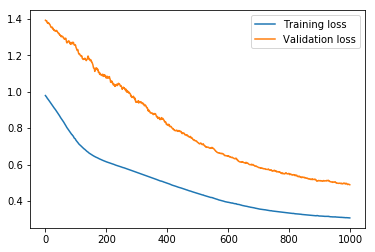

In [0]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

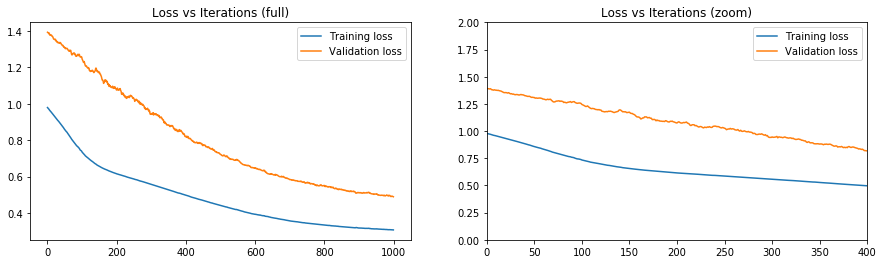

In [0]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(losses['train'], label='Training loss')
ax[0].plot(losses['validation'], label='Validation loss')
ax[0].legend()
ax[0].set_title('Loss vs Iterations (full)')
ax[1].plot(losses['train'], label='Training loss')
ax[1].plot(losses['validation'], label='Validation loss')
ax[1].legend()
ax[1].set_ylim([0,2])
ax[1].set_xlim([0,400])
ax[1].set_title('Loss vs Iterations (zoom)')
plt.show()
